# 2: Understanding Camera Models
In this workshop we saw how we can model a pinhole camera using the [Open CV pinhole camera model](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). We will in this notebook implement the pinhole camera model from scratch.

## Camera Matrix
The focal lenghts $f_x$ and $f_y$, and the principal points $c_x$ and $c_y$ make up the camera matrix ($K$), stored in a 3x3 matrix:

$$K = \left[\begin{array}{ccc} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{array}\right]$$

For our use we will save camera matrix as a `CameraMatrix` dataclass containing the focal lengths and the principal points. If we wanted the 3x3 matrix, we could add a method to get it.

In [1]:
from dataclasses import dataclass
from nptyping import Float32, NDArray, Shape

import numpy as np


@dataclass
class CameraMatrix:
    fx: float
    fy: float
    cx: float
    cy: float

### Normalizing the pixels
We can now normalize the pixels using the camera matrix. The function `normalize_pixels` takes a `HxWx2` array of pixels and a `CameraMatrix` and returns a `HxWx2` array of normalized pixels by applying the formula:

$$\begin{align*} x' &= \frac{x-c_x}{f_x} \\ y' &= \frac{y-c_y}{f_y} \end{align*}$$

In [2]:
def normalize_pixels(
    pixels: NDArray[Shape["H, W, 2"], Float32],
    camera_matrix: CameraMatrix,
) -> NDArray[Shape["H, W, 2"], Float32]:
    return pixels  # TODO: Implement this

### Denormalizing the pixels
We can also denormalize the pixels using the camera matrix. The function `denormalize_pixels` takes a `HxWx2` array of normalized pixels and a `CameraMatrix` and returns a `HxWx2` array of pixels by applying the formula:

$$\begin{align*} x &= f_x \cdot x' + c_x \\ y &= f_y \cdot y' + c_y \end{align*}$$

In [3]:
def denormalize_pixels(
    normalized_pixels: NDArray[Shape["H, W, 2"], Float32],
    camera_matrix: CameraMatrix,
) -> NDArray[Shape["H, W, 2"], Float32]:
    return normalized_pixels  # TODO: Implement this

### Example
To visualize the effect of focal lengths and principal points, we can load a simple test image:


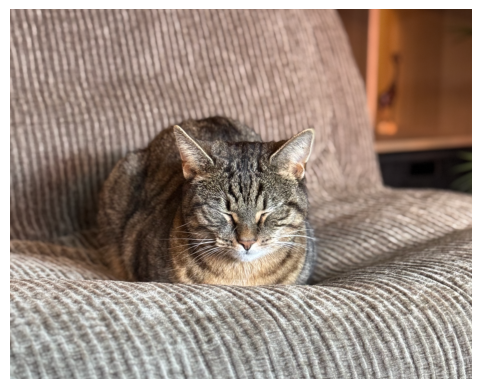

In [4]:
from matplotlib import pyplot as plt

from oaf_vision_3d._test_data_paths import TestDataPaths


image = plt.imread(TestDataPaths.lens_model_cat)

plt.figure()
plt.imshow(image)
plt.axis("off")
plt.show()

We can now overlay a grid that we can alter with the camera matrix:

$$
\left[\begin{array}{cc} x \\ y \end{array}\right] \xrightarrow[K]{\mathrm{normalize}}
\left[\begin{array}{cc} x' \\ y'\end{array}\right] \xrightarrow[K_0]{\mathrm{denormalize}}
\left[\begin{array}{cc} x* \\ y*\end{array}\right]
$$

In [5]:
from ipywidgets import interact, FloatSlider


def get_new_grid(
    pixels: np.ndarray,
    fx: float,
    fy: float,
    cx: float,
    cy: float,
    camera_matrix_0: CameraMatrix,
) -> np.ndarray:
    camera_matrix = CameraMatrix(fx=fx, fy=fy, cx=cx, cy=cy)
    normalized_pixels = normalize_pixels(pixels=pixels, camera_matrix=camera_matrix)
    return denormalize_pixels(
        normalized_pixels=normalized_pixels, camera_matrix=camera_matrix_0
    )


camera_matrix_0 = CameraMatrix(fx=2500.0, fy=2500.0, cx=1250, cy=1000)

pixels_grid = np.stack(
    np.meshgrid(
        np.linspace(0, image.shape[1] - 1, 11),
        np.linspace(0, image.shape[0] - 1, 9),
        indexing="ij",
    ),
    axis=-1,
    dtype=np.float32,
)


def plot_with_sliders(focal_lenght: float, cx: float, cy: float) -> None:
    new_pixels_grid = get_new_grid(
        pixels=pixels_grid,
        fx=focal_lenght,
        fy=focal_lenght,
        cx=cx,
        cy=cy,
        camera_matrix_0=camera_matrix_0,
    )

    plt.figure(figsize=(8, 10))
    plt.imshow(image)
    plt.plot(pixels_grid[..., 0], pixels_grid[..., 1], "-r")
    plt.plot(pixels_grid[..., 0].T, pixels_grid[..., 1].T, "-r")
    plt.plot(new_pixels_grid[..., 0], new_pixels_grid[..., 1], "-b")
    plt.plot(new_pixels_grid[..., 0].T, new_pixels_grid[..., 1].T, "-b")
    plt.axis("off")
    plt.xlim(-500, 2999)
    plt.ylim(2499, -500)
    plt.show()


_ = interact(
    plot_with_sliders,
    focal_lenght=FloatSlider(min=1500.0, max=3500.0, step=10.0, value=2500.0),
    cx=FloatSlider(min=750.0, max=1750.0, step=10.0, value=1250),
    cy=FloatSlider(min=500.0, max=1500.0, step=10.0, value=1000),
)

interactive(children=(FloatSlider(value=2500.0, description='focal_lenght', max=3500.0, min=1500.0, step=10.0)…

## Distortion Coefficients
In an ideal world, normalizing the pixels to vectors would be enough. However, in the real world, we have to account for distortion. In the OpenCV model, there are a total of 14 distortion coefficients. As with the camera matrix, we will save the distortion coefficients as a `DistortionCoefficients` dataclass.

In [6]:
@dataclass
class DistortionCoefficients:
    k1: float = 0.0
    k2: float = 0.0
    k3: float = 0.0
    k4: float = 0.0
    k5: float = 0.0
    k6: float = 0.0
    p1: float = 0.0
    p2: float = 0.0
    s1: float = 0.0
    s2: float = 0.0
    s3: float = 0.0
    s4: float = 0.0
    tau_x: float = 0.0
    tau_y: float = 0.0

### Distorting the pixels
In this section we will focus on implementing the first 5 distortion coefficients, $k_1$, $k_2$, $p_1$, $p_2$ and $k_3$. These parameters make up the radial and tangential distortion. The formula for distorting the pixels is:

$$\begin{align*} x_d &= x(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + 2p_1 x y + p_2(r^2 + 2x^2) \\ y_d &= y(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + p_1(r^2 + 2y^2) + 2p_2 x y \end{align*}$$

where $r^2 = x^2 + y^2$, and $x$ and $y$ is the normalized pixel values. We can seperate the effects:


$$\begin{align*} D_R &= (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\\\ \text{radial\_distortion}_x &= xD_R \\ \text{radial\_distortion}_y &= yD_R \\\\ \text{tangential\_distortion}_x &= 2p_1 x y + p_2(r^2 + 2x^2) \\ \text{tangential\_distortion}_y &= 2p_2 x y + p_1(r^2 + 2y^2) \\\\ xy_d &= \text{radial\_distortion} + \text{tangential\_distortion} \end{align*}$$

In [7]:
def distort_pixels_5(
    normalized_pixels: NDArray[Shape["H, W, 2"], Float32],
    distortion_coefficients: DistortionCoefficients,
) -> NDArray[Shape["H, W"], Float32]:
    return normalized_pixels  # TODO: Implement

### Example
We can show the same example as before, but now with distortion:

$$
\left[\begin{array}{cc} x \\ y \end{array}\right] \xrightarrow[K]{\mathrm{normalize}}
\left[\begin{array}{cc} x' \\ y'\end{array}\right] \xrightarrow[kc]{\mathrm{distort}}
\left[\begin{array}{cc} x'' \\ y''\end{array}\right] \xrightarrow[kc_0]{\mathrm{undistort}}
\left[\begin{array}{cc} x'^* \\ y'^*\end{array}\right] \xrightarrow[K_0]{\mathrm{denormalize}}
\left[\begin{array}{cc} x^* \\ y^*\end{array}\right]
$$

In [8]:
def get_new_grid_distortion_5(
    pixels: np.ndarray,
    k1: float,
    k2: float,
    k3: float,
    p1: float,
    p2: float,
    camera_matrix: CameraMatrix,
) -> np.ndarray:
    distortion_coefficients = DistortionCoefficients(k1=k1, k2=k2, k3=k3, p1=p1, p2=p2)
    normalized_pixels = normalize_pixels(pixels=pixels, camera_matrix=camera_matrix)
    distorted_normalized_pixels = distort_pixels_5(
        normalized_pixels=normalized_pixels,
        distortion_coefficients=distortion_coefficients,
    )
    new_normalized_pixels = distorted_normalized_pixels  # This works since we compare to 0 distortion. We need to do this since we haven't implemented the undistort function yet.
    return denormalize_pixels(
        normalized_pixels=new_normalized_pixels, camera_matrix=camera_matrix
    )


def plot_with_sliders_1(k1: float, k2: float, k3: float, p1: float, p2: float) -> None:
    new_pixels_grid = get_new_grid_distortion_5(
        pixels=pixels_grid,
        k1=k1,
        k2=k2,
        k3=k3,
        p1=p1,
        p2=p2,
        camera_matrix=camera_matrix_0,
    )

    plt.figure(figsize=(8, 10))
    plt.imshow(image)
    plt.plot(pixels_grid[..., 0], pixels_grid[..., 1], "-r")
    plt.plot(pixels_grid[..., 0].T, pixels_grid[..., 1].T, "-r")
    plt.plot(new_pixels_grid[..., 0], new_pixels_grid[..., 1], "-b")
    plt.plot(new_pixels_grid[..., 0].T, new_pixels_grid[..., 1].T, "-b")
    plt.axis("off")
    plt.xlim(-500, 2999)
    plt.ylim(2499, -500)
    plt.show()


_ = interact(
    plot_with_sliders_1,
    k1=FloatSlider(min=-0.4, max=1, step=0.1, value=0.0),
    k2=FloatSlider(min=-0.4, max=1, step=0.1, value=0.0),
    k3=FloatSlider(min=-0.4, max=1, step=0.1, value=0.0),
    p1=FloatSlider(min=-0.1, max=0.1, step=0.01, value=0.0),
    p2=FloatSlider(min=-0.1, max=0.1, step=0.01, value=0.0),
)

interactive(children=(FloatSlider(value=0.0, description='k1', max=1.0, min=-0.4), FloatSlider(value=0.0, desc…

## Full distortion
For those that want to try implementing the 14 coefficients, the full distortion formula is:

$$\begin{align*} D_R &= \frac{1 + k_1 r^2 + k_2 r^4 + k_3 r^6}{1 + k_4 r^2 + k_5 r^4 + k_6 r^6} \\\\ \text{radial\_distortion}_x &= xD_R \\ \text{radial\_distortion}_y &= yD_R \\\\ \text{tangential\_distortion}_x &= 2p_1 x y + p_2(r^2 + 2x^2) \\ \text{tangential\_distortion}_y &= 2p_2 x y + p_1(r^2 + 2y^2) \\\\ \text{thin\_prism\_distortion}_x &= s_1 r^2 + s_2 r^4 \\ \text{thin\_prism\_distortion}_y &= s_3 r^2 + s_4 r^4 \\\\ xy_d^* &= \text{radial\_distortion} + \text{tangential\_distortion} + \text{thin\_prism\_distortion} \end{align*}$$

The only difference is that we have added the full radial distortion and the thin prism distortion. The last distortion effect is tilt distortion and is applied to the above points as a 3x3 matrix:

$$\text{tilt\_matrix} = M_T = \left[\begin{array}{ccc} \cos(\tau_x) & 0 & 0 \\ -\sin(\tau_x)\sin(\tau_y) & \cos(\tau_y) & 0 \\ \sin(\tau_y) & -\sin(\tau_x)\cos(\tau_y) & \cos(\tau_x)\cos(\tau_y) \end{array}\right]$$

We then apply the matric using normal matrix multiplication:

$$ \begin{bmatrix} x^* \\ y^*  \\ z^* \end{bmatrix} = M_T \begin{bmatrix} x_d^* \\ y_d^* \\ 1 \end{bmatrix} $$

Where the distorted pixels are:

$$ \begin{align*} x_d &= \frac{x^*}{z^*} \\ y_d &= \frac{y^*}{z^*} \end{align*} $$


In [9]:
def distort_pixels(
    normalized_pixels: NDArray[Shape["H, W, 2"], Float32],
    distortion_coefficients: DistortionCoefficients,
) -> NDArray[Shape["H, W"], Float32]:
    return distort_pixels_5(
        normalized_pixels=normalized_pixels,
        distortion_coefficients=distortion_coefficients,
    )  # TODO: Implement

And here is the full plot to explore the distortion coefficients:

In [10]:
def get_new_grid_distortion(
    pixels: np.ndarray,
    camera_matrix: CameraMatrix,
    **kwargs,
) -> np.ndarray:
    distortion_coefficients = DistortionCoefficients(**kwargs)
    normalized_pixels = normalize_pixels(pixels=pixels, camera_matrix=camera_matrix)
    distorted_normalized_pixels = distort_pixels(
        normalized_pixels=normalized_pixels,
        distortion_coefficients=distortion_coefficients,
    )
    new_normalized_pixels = distorted_normalized_pixels  # This works since we compare to 0 distortion. We need to do this since we haven't implemented the undistort function yet.
    return denormalize_pixels(
        normalized_pixels=new_normalized_pixels, camera_matrix=camera_matrix
    )


def plot_with_sliders_2(
    k1: float,
    k2: float,
    k3: float,
    k4: float,
    k5: float,
    k6: float,
    p1: float,
    p2: float,
    s1: float,
    s2: float,
    s3: float,
    s4: float,
    tau_x: float,
    tau_y: float,
) -> None:
    new_pixels_grid = get_new_grid_distortion(
        pixels=pixels_grid,
        camera_matrix=camera_matrix_0,
        k1=k1,
        k2=k2,
        k3=k3,
        k4=k4,
        k5=k5,
        k6=k6,
        p1=p1,
        p2=p2,
        s1=s1,
        s2=s2,
        s3=s3,
        s4=s4,
        tau_x=tau_x,
        tau_y=tau_y,
    )

    plt.figure(figsize=(8, 10))
    plt.imshow(image)
    plt.plot(pixels_grid[..., 0], pixels_grid[..., 1], "-r")
    plt.plot(pixels_grid[..., 0].T, pixels_grid[..., 1].T, "-r")
    plt.plot(new_pixels_grid[..., 0], new_pixels_grid[..., 1], "-b")
    plt.plot(new_pixels_grid[..., 0].T, new_pixels_grid[..., 1].T, "-b")
    plt.axis("off")
    plt.xlim(-500, 2999)
    plt.ylim(2499, -500)
    plt.show()


_ = interact(
    plot_with_sliders_2,
    k1=FloatSlider(min=-0.4, max=1, step=0.1, value=0.0),
    k2=FloatSlider(min=-0.4, max=1, step=0.1, value=0.0),
    k3=FloatSlider(min=-0.4, max=1, step=0.1, value=0.0),
    k4=FloatSlider(min=-1, max=1, step=0.1, value=0.0),
    k5=FloatSlider(min=-1, max=1, step=0.1, value=0.0),
    k6=FloatSlider(min=-1, max=1, step=0.1, value=0.0),
    p1=FloatSlider(min=-0.1, max=0.1, step=0.01, value=0.0),
    p2=FloatSlider(min=-0.1, max=0.1, step=0.01, value=0.0),
    s1=FloatSlider(min=-0.2, max=0.2, step=0.01, value=0.0),
    s2=FloatSlider(min=-0.2, max=0.2, step=0.01, value=0.0),
    s3=FloatSlider(min=-0.2, max=0.2, step=0.01, value=0.0),
    s4=FloatSlider(min=-0.2, max=0.2, step=0.01, value=0.0),
    tau_x=FloatSlider(min=-0.2, max=0.2, step=0.01, value=0.0),
    tau_y=FloatSlider(min=-0.2, max=0.2, step=0.01, value=0.0),
)

interactive(children=(FloatSlider(value=0.0, description='k1', max=1.0, min=-0.4), FloatSlider(value=0.0, desc…